In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ROOT
import glob
import sys
import os
import tqdm

import shield_optimization as so

In module 'Darwin':
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:14:1: error: '_OSSwapInt16' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint16_t' (aka 'unsigned short')
uint16_t
^~~~~~~~
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/_OSByteOrder.h:49:1: note: but in 'DarwinFoundation.OSByteOrder' found different return type '__uint16_t' (aka 'unsigned short')
__uint16_t
^~~~~~~~~~
In module 'Darwin':
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:24:1: error: '_OSSwapInt32' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint32_t' (aka 'unsigned int')
uint32_t
^~~~~~~~


Welcome to JupyROOT 6.30/04


In [ ]:
# neutron separation energy of Cf-252
Sn = 6.172 # MeV (energy of emitted neutron)

activity = 19858367638938. # Bq/g (total decays, alphas and neutrons) [2]

mCu = 37000000 # one millicurie in Bq

neutron_rate = 2.314e6 # neutrons / sec / ug [1]
neutron_frac = 3.092/100 # fraction of neutrons (remainder alpha decays) [1]

density = 15.1 # g/cm^3 (wikipedia)

Si_density = 2.33 # g/cm^3 (from google)

#typical_purity = mCu/(0.1**3)/density/activity # set so that total is one mCu

typical_purity = 1/4800 # typical fraction of Cf source that has active Cf-252 (numbers from [1] - ish: 5 cm x 1 cm radius block contains ~50 mg of Cf-252)

volume = 0.1**3 # volume (cm^3)
active_mass = density*volume*typical_purity # grams
total_activity = active_mass*activity # Bq (decays per second)

samplerate = neutron_rate*1e6*density*volume*typical_purity # emission rate (neutrons per second)


# [1] https://doi.org/10.1016/S0969-8043(00)00214-1
# [2] https://doi.org/10.1016/j.anucene.2023.109699 
# other: https://www.chemlin.org/isotope/californium-252

def exposure_time(Nprimaries):
    # seconds corresponding to Nprimaries
    return Nprimaries/total_activity

def mCu_exposure_time(Nprimaries):
    return Nprimaries/mCu

In [4]:
print(total_activity/mCu)

1.688408509842139


In [5]:
def convert_to_one_mCu(rate):
    return rate*mCu/total_activity

convert_to_one_mCu(0.03)

0.01776821179538174

In [6]:
detectors = ['lowmass', 'highmass1', 'highmass2']
def get_rates(*files):
    counts = {det: 0 for det in detectors}
    ncounts = {det: 0 for det in detectors}

    if len(files) < 10:
        tree_iter = lambda N: tqdm.trange(N)
        file_iter = files
    else:
        tree_iter = lambda N: range(N)
        file_iter = tqdm.tqdm(files)
        


    for file in file_iter:
        last_event = -1
        hits = {det: 0 for det in detectors}
        tfile = ROOT.TFile.Open(file, 'READ')
        tree = tfile.Get('tree')
        N = tree.GetEntries()

        for k in tree_iter(N):
            tree.GetEntry(k)
            EventNum = int(getattr(tree, 'EventNum'))
            VolName = getattr(tree, 'VolName')
            ProcName = getattr(tree, 'ProcName')
            hits[VolName] += 1


            if ProcName == 'nCapture':
                ParentVol = getattr(tree, 'ParentVol')

                if (ParentVol == VolName) and (getattr(tree, 'PName') != 'gamma'):
                    ncounts[VolName] += 1

            if abs(EventNum - last_event) > 1e-6: # new event
                last_event = EventNum
                for det in detectors:
                    if hits[det] > 0:
                        counts[det] += 1
                
                hits = {det: 0 for det in detectors}

        tfile.Close()

    return counts, ncounts



In [7]:
Nprimaries = 5e5
T = exposure_time(Nprimaries)
files_15_10 = [
    #'../build/test_data/ratesim_20250109_125611_t0.root',
    '../build/test_data/ratesim_20250109_130755_t0.root',
] # 5.5e6 primaries

files_15_5 = [
    '../build/test_data/ratesim_20250109_133224_t0.root'
] # 5e6 primaries

files_10_5 = [
    '../build/test_data/ratesim_20250109_135033_t0.root'
] # 5e6 primaries

files_10_10 = [
    '../build/test_data/ratesim_20250109_140549_t0.root'
] # 5e6 primaries

files_10_15 = [
    '../build/test_data/ratesim_20250109_142831_t0.root'
] # 5e6 primaries

files_15_15 = [
    '../build/test_data/ratesim_20250109_144110_t0.root'
] # 5e6 primaries

files_20_5 = [
    '../build/test_data/ratesim_20250109_150118_t0.root'
] # 5e6 primaries
# takeaways: not enough poly. For the same distance from the source, way more background events (and a fair amount of neutronElastic/neutronInelastic)

files_15_5_v2 = glob.glob('../build/rate_data_15_5/ratesim_20250111_??????_t?.root')
# 41*5e6 primaries

files_12_5_v2 = glob.glob('../build/rate_data_12_5/ratesim2025011?_??????_t?.root')
# 40*5e6 primaries

files_10_5_v2 = glob.glob('../build/rate_data_10_5/ratesim_20250112_??????_t?.root')
# 40*5e6 primaries

counts, ncounts = get_rates(*files_10_5_v2)
T = exposure_time(40*50e6)

for det in detectors:
    print(f'{det}: {counts[det]/T/1e3:.4g} kHz ({counts[det]:.3g} counts)')
    print(f'    captures: {ncounts[det]/T:.4g} Hz ({ncounts[det]:.3g} counts)')

lowmass: 0 kHz (0 counts)
    captures: 0 Hz (0 counts)
highmass1: 0 kHz (0 counts)
    captures: 0 Hz (0 counts)
highmass2: 0 kHz (0 counts)
    captures: 0 Hz (0 counts)


In [189]:
counts, ncounts = get_rates(*glob.glob('../build/shield_sim/Lead10_PE5*.root'))

T = mCu_exposure_time(2*1e8)

for det in detectors:
    print(f'{det}: {counts[det]/T/1e3:.4g} kHz ({counts[det]:.3g} counts)')
    print(f'    captures: {ncounts[det]/T:.4g} Hz ({ncounts[det]:.3g} counts)')

100%|██████████| 16/16 [00:04<00:00,  3.91it/s]

lowmass: 0.01869 kHz (101 counts)
    captures: 1.11 Hz (6 counts)
highmass1: 32.46 kHz (1.75e+05 counts)
    captures: 1e+04 Hz (5.41e+04 counts)
highmass2: 23.35 kHz (1.26e+05 counts)
    captures: 6640 Hz (3.59e+04 counts)


In [8]:
counts

{'lowmass': 0, 'highmass1': 0, 'highmass2': 0}

In [9]:
ncounts

{'lowmass': 0, 'highmass1': 0, 'highmass2': 0}

In [10]:
np.sqrt(3)/exposure_time(40*50e6)*mCu/total_activity

0.03204293994002423

In [11]:
9.39*mCu/total_activity

5.561450291954484

In [12]:
exposure_time(40*50e6)

32.014796027714844

In [13]:
iontable = 'simdata_20250114_121957_t0.root' # using first versions of throwing ions directly

In [159]:
# approx neutron hadElastic rate in highmass 1
fname = '../build/rate_sim/simdata_nogammas2_20250205_155803_t0.root'

def hadElasticRate(fname, volname = 'highmass1', procname = 'hadElastic'):
    tfile = ROOT.TFile.Open(fname, 'READ')
    tree = tfile.Get('tree')
    N = tree.GetEntries()
    Nevts = 0
    last_event = -1
    hit = False
    for k in range(N):
        tree.GetEntry(k)
        EventNum = int(getattr(tree, 'EventNum'))
        VolName = getattr(tree, 'VolName')
        ProcName = getattr(tree, 'ProcName')

        if abs(EventNum - last_event) > 1e-6: # new event
            if hit:
                Nevts += 1
            hit = False
            last_event = EventNum

        if VolName == volname and ProcName == procname:
            hit = True

    tfile.Close()
    return Nevts

nhadElastic = hadElasticRate(fname)

In [160]:
nhadElastic

1273

In [161]:
1273/mCu_exposure_time(1e7) # Hz

4710.099999999999

In [162]:
# 7 cm PE
#ff = 'simdata_nolead_20250211_162433'
#ff = 'simdata_nolead_20250213_133837'

# 8 cm PE
#ff = 'simdata_nolead_20250207_130303' # 100M primaries
#ff = 'simdata_nolead_20250213_140832'

# 9 cm PE
#ff = 'simdata_nolead_20250207_164528'
#ff = 'simdata_nolead_20250213_154036'

# 10 cm PE
#ff = 'simdata_nolead_20250207_122926' # 100M primaries
#ff = 'simdata_nolead_20250207_121842' # 10M primaries
#ff = 'simdata_nolead_20250213_162939'

# 11 cm PE
#ff = 'simdata_nolead_20250211_155448'
ff = 'simdata_nolead_20250213_165859'

files = glob.glob(f'../build/rate_sim/{ff}_t?.root')
for proc, vol in zip(('nCapture', 'hadElastic', 'nCapture'), ('highmass1', 'highmass1', 'lowmass')):
    nHits = sum(hadElasticRate(file, procname = proc, volname = vol) for file in files)
    print(vol, proc, nHits)


highmass1 nCapture 46113
highmass1 hadElastic 112234
lowmass nCapture 3


In [163]:
mCu_exposure_time(1e8)

2.7027027027027026

In [164]:
8/mCu_exposure_time(1e8)

2.96

In [270]:
importlib.reload(so)

match = 'Lead*_PE*_????????_??????_t?.root'

opt = so.ShieldOptimization(match = match, Ndefault = 1e8, verbose = 1)
opt.analyze()

print(opt.rates)

collecting 40 files
1/40 done
5/40 done
9/40 done
13/40 done
17/40 done
21/40 done
25/40 done
29/40 done
33/40 done
37/40 done
{(10.0, 5.0): array([[2.5758475e+04, 9.9655800e+03],
       [1.6159750e+04, 6.6220750e+03],
       [1.7575000e+01, 1.1100000e+00]]), (10.0, 6.0): array([[1.9102545e+04, 7.5348650e+03],
       [1.2029070e+04, 5.0210850e+03],
       [1.2025000e+01, 7.4000000e-01]]), (10.0, 4.0): array([[3.480590e+04, 1.337217e+04],
       [2.172677e+04, 8.867420e+03],
       [2.072000e+01, 7.400000e-01]])}


In [282]:
for poly in (4.,5.,6.):
    r = opt.get_rate(lead = 10., poly = poly, det = 'lowmass', proc = 'nCapture')
    n = opt.totals[(10.,poly)][(2,1)]
    print(f'10 cm lead, {poly:.0f} cm poly: {r:.4g} Hz captures in lowmass ({n:.0f} captures)')

10 cm lead, 4 cm poly: 0.74 Hz captures in lowmass (2 captures)
10 cm lead, 5 cm poly: 1.11 Hz captures in lowmass (6 captures)
10 cm lead, 6 cm poly: 0.74 Hz captures in lowmass (4 captures)


Text(0, 0.5, 'capture rate [Hz]')

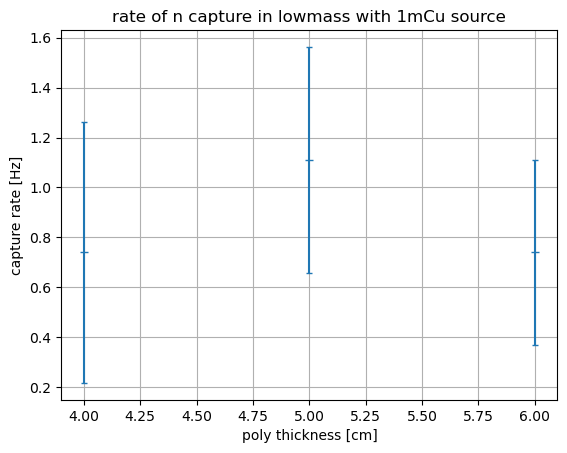

In [283]:
lead, poly, rate, drate = opt.get_capture_rate()

plt.errorbar(poly, rate, yerr = drate, linestyle = '', marker = '_', capsize = 2)
plt.grid()
plt.title('rate of n capture in lowmass with 1mCu source')
plt.xlabel('poly thickness [cm]')
plt.ylabel('capture rate [Hz]')

In [284]:
opt.rates[(10.,5.)][(2,1)]

1.1100000000000003

In [285]:
# file with one capture
hadElasticRate('../build/shield_sim/Lead10_PE4_20250215_202507_t1.root', procname = 'nCapture', volname = 'lowmass')

1

In [286]:
# read ShieldOptimization data from pickled Grace data
import pickle
with open('analysis_data/shield_opt.dat', 'rb') as file:
    opt_grace = pickle.load(file)

Text(0, 0.5, 'capture rate [Hz]')

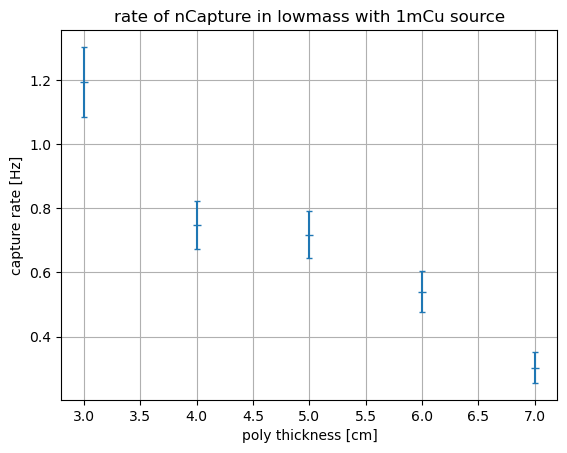

In [293]:
lead, poly, rate, drate = opt_grace.get_capture_rate()

plt.errorbar(poly, rate, yerr = drate, linestyle = '', marker = '_', capsize = 2)
plt.grid()
plt.title('rate of nCapture in lowmass with 1mCu source')
plt.xlabel('poly thickness [cm]')
plt.ylabel('capture rate [Hz]')

In [294]:
opt_grace.totals[(10.,5.)][opt_grace.rates_accessor['lowmass']['nCapture']]

97.0

In [295]:
opt.rates[(10.,5.)][2,1], opt_grace.rates[(10.,5.)][2,1], '+/-', opt_grace.drates[(10.,5.)][2,1]

(1.1100000000000003, 0.7177999999999995, '+/-', 0.07288154773329113)

In [296]:
r1[2,1]-r2[2,1], dr[2,1]

(-0.39220000000000077, 0.07288154773329113)

In [297]:
geom = (10.,5.)
r1 = opt_grace.rates[geom]
dr = opt_grace.drates[geom]
r2 = opt.rates[geom]

print('relative errors')
print((r1-r2)/r1)
print('sigma errors')
print((r1-r2)/dr)

relative errors
[[-7.44121156e-05  3.58257457e-03]
 [-2.23417331e-03  1.25669503e-03]
 [-5.93220339e-02 -5.46391753e-01]]
sigma errors
[[-0.13882629  4.16495211]
 [-3.29787138  1.18955395]
 [-2.80888421 -5.38133468]]


In [377]:
# testing airgaps between source and poly 

opt_gap = so.ShieldOptimization(match = 'Air*_PE*_*_t?.root', folder = '../build/gap_sim/', Ndefault = 1e7, verbose = 3, part = 10)
opt_gap.analyze()

collecting 1328 files
1/1328 done
133/1328 done
265/1328 done
397/1328 done
529/1328 done
661/1328 done
793/1328 done
925/1328 done
1057/1328 done
1189/1328 done
1321/1328 done


Text(0, 0.5, 'capture rate [Hz]')

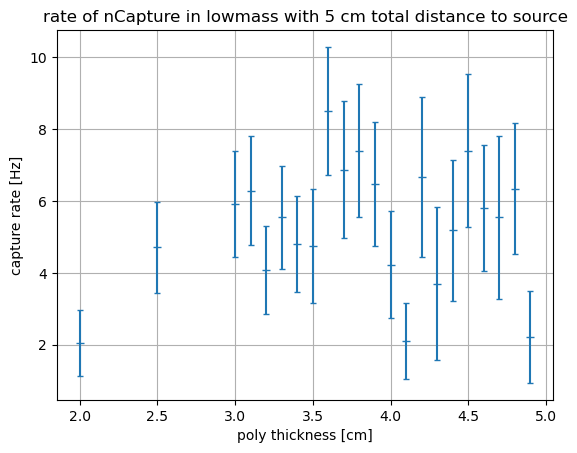

In [380]:
lead, poly, rate, drate = opt_gap.get_capture_rate()

plt.errorbar(poly, rate, yerr = drate, linestyle = '', marker = '_', capsize = 2)
plt.grid()
plt.title('rate of nCapture in lowmass with 5 cm total distance to source')
plt.xlabel('poly thickness [cm]')
plt.ylabel('capture rate [Hz]')

In [381]:
poly+lead

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5.])